In [150]:
import pywavefront
import numpy as np
import os
import sys
import rclpy
import numpy as np
import scipy.sparse as spa
import osqp
from matplotlib.pyplot import plot as plot

from matplotlib.pyplot import scatter as scatter
if '/home/paul/CLionProjects/thesis_nerf/scripts' not in sys.path:
    sys.path.append('/home/paul/CLionProjects/thesis_nerf/scripts')
if not rclpy.ok():
    rclpy.init()
from point_cloud_utils import send_point_cloud
    
def send_points(points, color, topic):
    if color.size==3:
        colors = np.zeros(points.shape)+color
    else:
        colors = color
    rgb_points = np.hstack((points, colors))
    send_point_cloud(rgb_points, has_alpha=False,topic=topic)

def get_vert_np():
    obj = 'truck.obj'
#     obj = 'block.obj'
#     obj = 'monkey.obj'
#     obj = 'long.obj'
    scene = pywavefront.Wavefront(obj, parse=True)
    return np.array(scene.vertices)

def radial_basis(x, center, width):
    # spatial axis is 0, dim axis is 1 
    assert(len(center.shape)==len(x.shape))
    assert(len(center.shape)==2)
    assert(center.shape[1]==x.shape[1])
    num_dims = x.shape[1]
    num_centers = centers.shape[0]
    num_x = x.shape[0]
    center_shape = [1, num_dims, num_centers]
    center = np.reshape(center, center_shape)
    x_shape = [num_x, num_dims, 1]
    x = np.reshape(x, x_shape)
    
    dist = (x - center)**2
    dist = np.sqrt(np.sum(dist, axis=1))
    mVal = np.exp(-1/width*dist**2);
    return mVal

def quadprog(P, q, G=None, h=None, A=None, b=None,
             initvals=None, verbose=True):
    l = -np.inf * np.ones(len(h))
    if A is not None:
        qp_A = spa.vstack([G, A]).tocsc()
        qp_l = np.hstack([l, b])
        qp_u = np.hstack([h, b])
    else:  # no equality constraint
        qp_A = G
        qp_l = l
        qp_u = h
    model = osqp.OSQP()
    model.setup(P=P, q=q,
                A=qp_A, l=qp_l, u=qp_u, verbose=verbose)
    if initvals is not None:
        model.warm_start(x=initvals)
    results = model.solve()
    return results.x, results.info.status

vert_np = get_vert_np()

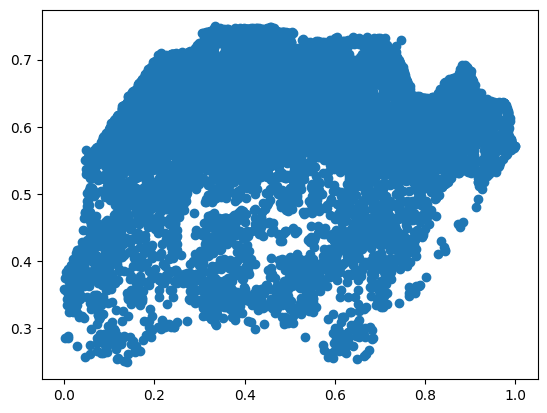

In [151]:
uv = np.zeros(vert_np.shape)
uv[:,:2] = vert_np[:,:2]+np.reshape(vert_np[:,2],(-1,1))
uv = uv-np.min(uv)
uv = uv/np.max(uv)
send_points(vert_np, uv, topic='point_cloud')

scatter(uv[:, 0], uv[:, 1])

# Generate problem data
n = 2   # Variables
H = spa.csc_matrix([[4, 1], [1, 2]])
f = np.array([1, 1])
G = spa.csc_matrix([[1, 0], [0, 1]])
h = np.array([0.7, 0.7])
A = spa.csc_matrix([[1, 1]])
b = np.array([1.])



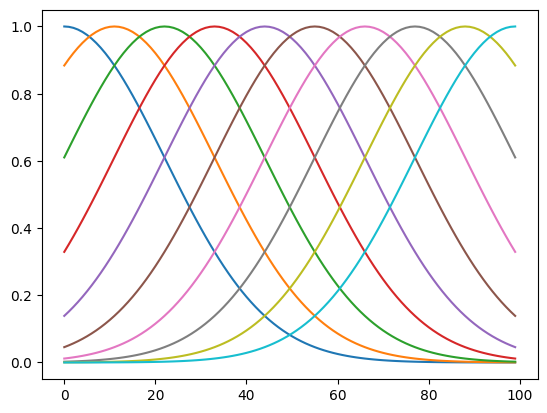

In [153]:
x = np.linspace([0], [1], 100)
centers = np.linspace([0], [1], 10)
A = radial_basis(x, centers, .1)
plot(A)


In [192]:
x = np.linspace(0, 1, 80)
y = np.linspace(0, 1, 80)
xv, yv = np.meshgrid(x, y, indexing='xy')
X = np.reshape(np.hstack((xv.flatten(), yv.flatten())) , (2, -1)).transpose()

x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
xv, yv = np.meshgrid(x, y, indexing='xy')
centers = np.reshape(np.hstack((xv.flatten(), yv.flatten())), (-1,2))
A = radial_basis(X, centers, .1)
print(X.shape)
print(A.shape)


points = []
color = []
for i in range(A.shape[1]):
    points.append(np.hstack((X, np.expand_dims(A[:,i],1))))
    c = np.random.normal([0,0,0], [1,1,1], 3)
    c = abs(c)/np.linalg.norm(c)
    color.append(c*np.ones(points[-1].shape))

    
points = np.vstack(points)
color = np.vstack(color)
send_points(points, color,topic='point_cloud')


(6400, 2)
(6400, 25)


In [190]:
points.shape

(250000, 3)

In [155]:
send_points(pred_np, np.array([0,1,0]),topic='point_cloud_2')
send_points(vert_np, np.array([.7,.7,.7]),topic='point_cloud')

NameError: name 'pred_np' is not defined

In [34]:

# Initial point
q0 = np.ones(n)

x, status = quadprog(H, f, G, h, A, b, initvals=q0, verbose=False)

array([0.29951897, 0.70048067])